In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier

## Read in the data

First read in the data. We'll get both the training and testing datasets here, and concatenate them, so that we can apply any feature modifications/additions to all of the data in one hit. We'll also record the size of the training set, and the passenger id numbers, as we'll need these later on for splitting the data, and for the final submission.

In [2]:
train_data = pd.read_csv('./data/train.csv')
train_size = len(train_data)
test_data = pd.read_csv('./data/test.csv')
all_data = pd.concat([train_data, test_data], axis=0, sort=False)
ids = all_data['PassengerId']

It looks like this:

In [3]:
all_data.head()

PassengerId  Survived  Pclass  \
0            1       0.0       3   
1            2       1.0       1   
2            3       1.0       3   
3            4       1.0       1   
4            5       0.0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

We can immediately drop a few features. It's safe to assume that passenger id will not contain any predictive information. We'll also assume this for ticket number.

In [4]:
all_data.drop(['PassengerId', 'Ticket'], axis=1, inplace=True)

## Fill missing values

Here's what the nan (actually non-nan) counts look like for each feature:

In [5]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 10 columns):
Survived    891 non-null float64
Pclass      1309 non-null int64
Name        1309 non-null object
Sex         1309 non-null object
Age         1046 non-null float64
SibSp       1309 non-null int64
Parch       1309 non-null int64
Fare        1308 non-null float64
Cabin       295 non-null object
Embarked    1307 non-null object
dtypes: float64(3), int64(3), object(4)
memory usage: 112.5+ KB


If we want to use all of our samples (and we have to for the submission), we'll need to apply some reasonable nan-fillers to the necessary samples/features. Age and fare are float fields, and is reasonable to assume that these vary according to class. Let's quantify this:

In [6]:
medians = all_data[['Pclass', 'Age', 'Fare']].groupby('Pclass').median()
print(medians)

         Age     Fare
Pclass               
1       39.0  60.0000
2       29.0  15.0458
3       24.0   8.0500


Indeed, there's significant variation between the median values of these features for each class. So let's use these medians to fill any missing entries for these two features:

In [7]:
for i in [1, 2, 3]:
    filled = all_data[all_data['Pclass'] == i]
    median_age = medians.loc[i,'Age']
    median_fare = medians.loc[i,'Fare']
    filled.fillna({'Age': median_age, 'Fare': median_fare}, inplace=True)
    all_data[all_data['Pclass'] == i] = filled

/Users/Ben/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Now for the ports of embarkation.

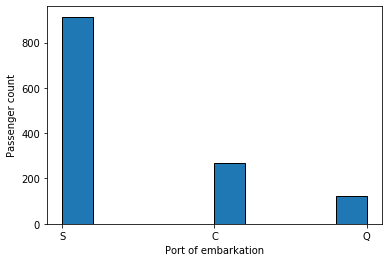

In [8]:
plt.hist(all_data['Embarked'].dropna(), edgecolor='k', linewidth=1)
plt.xlabel('Port of embarkation')
plt.ylabel('Passenger count')
plt.show()

As we're only missing two values here, let's use mode as the filler. Port 'S' (Southampton) clearly had the greatest number of passengers, so let's assume the missing values to be 'S'.

In [9]:
all_data.fillna({'Embarked': 'S'}, inplace=True)

Now that we've filled some missing data, let's explore the data have.

## Exploring the relationship between class, sex, and survival

How do survival rates vary according to class and gender? We can group the training data (which contains survival information) by class and gender to explore this.

In [10]:
pclass_groupby = (
    all_data.iloc[:train_size][['Pclass', 'Sex', 'Survived']]
).groupby(['Pclass', 'Sex'])['Survived']
pclass_count = pclass_groupby.size()
pclass_survived = pclass_groupby.sum()

As an example, here's what the count data looks like:

In [11]:
print(pclass_count)

Pclass  Sex   
1       female     94
        male      122
2       female     76
        male      108
3       female    144
        male      347
Name: Survived, dtype: int64


Plotting all of this on some bar charts:

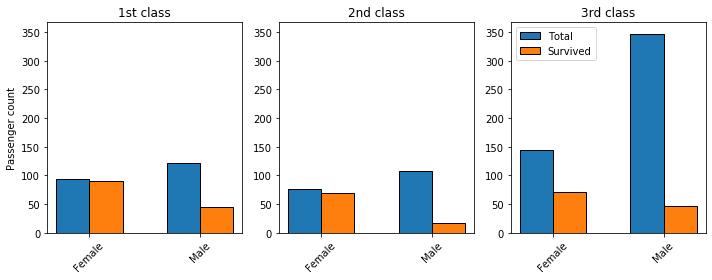

In [12]:
upper = np.max(pclass_count) + 20
width = 0.3
x = np.array([0, 1])
plt.figure(figsize=(10,4))
for i in [1, 2, 3]:
    plt.subplot(1, 3, i)
    plt.bar(x - width / 2, pclass_count[i], width=width, edgecolor='k', linewidth=1, label='Total')
    plt.bar(x + width / 2, pclass_survived[i], width=width, edgecolor='k', linewidth=1, label='Survived')
    plt.xticks(x, ['Female', 'Male'], rotation=45)
    plt.ylim((0, upper))
    if i == 1:
        plt.ylabel('Passenger count')
        title = '1st class'
    elif i ==2:
        title = '2nd class'
    else:
        title = '3rd class'
    plt.title(title)
plt.legend()
plt.tight_layout()
plt.show()

Chances of survival pretty clearly drops as we go down in class. This applies to both females and males. Also, females have a much higher chance of survival than males for all classes.

## Exploring the relation ship between age and survival

How did age play on the chances of survival? Did this vary according to gender? Let's bin the data according to age to explore this question.

In [13]:
# highest age on the ship
print(np.max(all_data.iloc[:train_size]['Age']))

80.0


Specifically, we'll bin the data using 10-year buckets:

In [14]:
age_bins = np.linspace(0, 80, 9).astype(int)
age_data = all_data.iloc[:train_size][['Sex', 'Age', 'Survived']]
age_data['Age_bin'] = pd.cut(age_data['Age'], age_bins)

In [15]:
age_groupby = age_data.groupby(['Sex', 'Age_bin'])['Survived']
age_survived = age_groupby.apply(lambda x: x.sum() / len(x))
print(age_survived)

Sex     Age_bin 
female  (0, 10]     0.612903
        (10, 20]    0.739130
        (20, 30]    0.704000
        (30, 40]    0.859375
        (40, 50]    0.677419
        (50, 60]    0.928571
        (60, 70]    1.000000
male    (0, 10]     0.575758
        (10, 20]    0.144928
        (20, 30]    0.134921
        (30, 40]    0.231405
        (40, 50]    0.218182
        (50, 60]    0.142857
        (60, 70]    0.071429
        (70, 80]    0.200000
Name: Survived, dtype: float64


Plotting this on some bar charts we get:

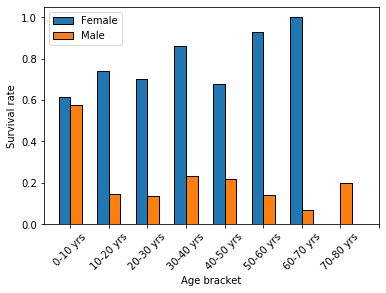

In [16]:
width = 0.3
plt.bar(
    np.array(range(len(age_survived.loc['female']))) - width / 2, 
    age_survived.loc['female'],
    width=width,
    edgecolor='k', 
    linewidth=1, 
    label='Female'
)
plt.bar(
    np.array(range(len(age_survived.loc['male']))) + width / 2, 
    age_survived.loc['male'],
    width=width,
    edgecolor='k', 
    linewidth=1, 
    label='Male',
)
bins_text = []
for i in range(len(age_bins) - 1):
    bins_text.append(f'{age_bins[i]}-{age_bins[i+1]} yrs')
plt.xticks(age_bins / 10, bins_text, rotation=45)
plt.xlabel('Age bracket')
plt.ylabel('Survival rate')
plt.legend()
plt.show()

Interestingly, an almost inverse relationship exists between female and male survival rates with age. Young children of both genders had similar chances of survival. Beyond this age, older women appear to have had a greater chance of survival, whereas older men had a much lower chance.

## Exploring the relationship between title and survival

A lot of titles (e.g. Mr., Mrs.) are directly related to gender, and don't give much information beyond that. There are some titles, however, that might carry with them some additional implications for the chances of survival of the holder of the title. For example, were any nobility on board expedited to the life boats? Were doctors held back by the need to help people injured in the panic? There may be some predictive ability gained from this information.

In [17]:
all_data['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

To extract an individual's title, we need a function that handles the name strings above:

In [18]:
def get_title(name):
    names = name.split()
    for i in names:
        # titles seem to end in a full stop, so use this as the identifier
        if i[-1] == '.':
            return i[:-1]
    return

In [19]:
all_data['Title'] = all_data['Name'].map(get_title)

Here are all the titles present on board the ship:

In [20]:
print(set(all_data.iloc[:train_size]['Title']))

{'Major', 'Dr', 'Jonkheer', 'Capt', 'Col', 'Mlle', 'Countess', 'Rev', 'Mme', 'Lady', 'Master', 'Ms', 'Don', 'Sir', 'Miss', 'Mrs', 'Mr'}


In [21]:
title_groupby = all_data.iloc[:train_size][['Title', 'Survived']].groupby('Title')['Survived']
title_counts = title_groupby.size()
title_survived = title_groupby.sum()

Now let's pull out the titles which are not simply gender and age related, and plot the counts and survivals for these. We'll further restrict these to only titles which are also present in the submission dataset:

In [22]:
print(set(all_data.iloc[train_size:]['Title']) & set(all_data.iloc[:train_size]['Title']))

{'Dr', 'Col', 'Rev', 'Master', 'Ms', 'Miss', 'Mrs', 'Mr'}


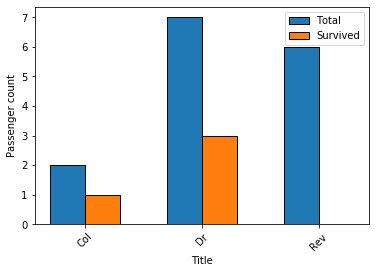

In [23]:
functional_titles = ['Col', 'Dr', 'Rev']
x = np.array(range(len(functional_titles)))
width = 0.3
plt.bar(
    x - width / 2, 
    title_counts.loc[functional_titles], 
    width=width, 
    label='Total', 
    edgecolor='k', 
    linewidth=1
)
plt.bar(
    x + width / 2, 
    title_survived.loc[functional_titles], 
    width=width, 
    label='Survived', 
    edgecolor='k', 
    linewidth=1
)
plt.xticks(x, functional_titles, rotation=45)
plt.xlabel('Title')
plt.ylabel('Passenger count')
plt.legend()
plt.show()

Arguably the most interesting result here is that none of six reverends present in the train/test data survived. Also, doctors had a fairly low survival rate (though this probably has a bit to do with the fact that they were likely all male).

## Exploring the effect of cabin/deck on survival

Were some cabins disadvantaged due to the proximity to damage to the ship, or proximity to lifeboats? There is a lot of missing data on cabin numbers in the dataset, and of that does exist, there are 187 unique cabins:

In [24]:
cabins = set(all_data['Cabin'])
print(cabins)

{nan, 'E10', 'C116', 'E77', 'C87', 'E40', 'C30', 'C62 C64', 'B35', 'C53', 'G6', 'C54', 'D22', 'E60', 'D56', 'D45', 'E45', 'A14', 'B18', 'E25', 'B45', 'C70', 'F E57', 'F38', 'D20', 'B38', 'B52 B54 B56', 'E67', 'T', 'A6', 'A36', 'C118', 'D', 'B37', 'B73', 'B57 B59 B63 B66', 'C80', 'D35', 'C99', 'C65', 'A29', 'B24', 'A18', 'B5', 'C130', 'F G73', 'F', 'E101', 'C95', 'D49', 'E63', 'C124', 'C101', 'B102', 'C55 C57', 'A31', 'E121', 'A19', 'C123', 'C128', 'B39', 'C31', 'E31', 'C47', 'D43', 'C83', 'C104', 'B41', 'B61', 'E52', 'B77', 'A9', 'F4', 'C105', 'B42', 'B78', 'B58 B60', 'A23', 'C7', 'C46', 'D11', 'D28', 'B3', 'C50', 'B11', 'C132', 'B19', 'A7', 'D19', 'C91', 'D37', 'C45', 'E49', 'C97', 'B36', 'D21', 'B94', 'B50', 'B80', 'A21', 'E33', 'D48', 'B71', 'F2', 'A16', 'C90', 'C51', 'B96 B98', 'C39', 'C52', 'C111', 'E36', 'D50', 'A24', 'D9', 'B22', 'C148', 'B30', 'F E69', 'E39 E41', 'C125', 'C106', 'C86', 'A34', 'B82 B84', 'A10', 'C85', 'B10', 'D40', 'A32', 'C126', 'E46', 'F E46', 'C49', 'E44', 'C

In [25]:
len(cabins)

187

Fortunately though, each of these cabins are prefixed by their respective deck (i.e. A, B, C etc.). To reduce the dimensionality of this data, let's pull out the deck for each existing entry:

In [26]:
def get_deck(cabin):
    try:
        return cabin[0]
    except:
        return cabin

In [27]:
deck = all_data['Cabin'].map(get_deck)
print(set(deck))

{nan, 'D', 'C', 'F', 'T', 'E', 'G', 'A', 'B'}


In [28]:
all_data['Deck'] = deck

Analogous to the previous sections, let's see how survival varied based on deck:

In [29]:
deck_groupby = all_data.iloc[:train_size][['Deck', 'Survived']].groupby('Deck')['Survived']
deck_counts = deck_groupby.size()
deck_survived = deck_groupby.sum()

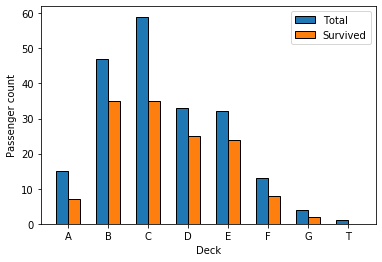

In [30]:
x = np.array(range(len(deck_counts.index)))
width = 0.3
plt.bar(x - width / 2, deck_counts, width=width, label='Total', edgecolor='k', linewidth=1)
plt.bar(x + width / 2, deck_survived, width=width, label='Survived', edgecolor='k', linewidth=1)
plt.xticks(x, deck_counts.index)
plt.xlabel('Deck')
plt.ylabel('Passenger count')
plt.legend()
plt.show()

It looks as though passengers on deck C had the least chance of survival, while passengers on D had the highest.

## Exploring the relationship between port of embarkation and survival

Did the port from which the passenger embarked influence their chances of survival? Conceivably, this feature may have some relationship to cabin/deck, or perhaps passenger class. Let's explore this:

In [31]:
embark_groupby = (
    all_data[:train_size][['Pclass', 'Embarked', 'Survived']]
).groupby(['Pclass', 'Embarked'])['Survived']
embark_counts = embark_groupby.size()
embark_survived = embark_groupby.sum()
print(embark_counts)

Pclass  Embarked
1       C            85
        Q             2
        S           129
2       C            17
        Q             3
        S           164
3       C            66
        Q            72
        S           353
Name: Survived, dtype: int64


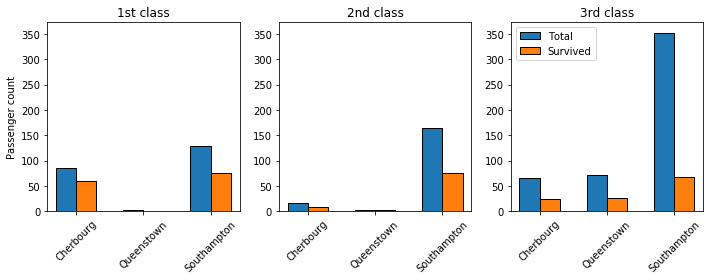

In [32]:
upper = np.max(embark_counts) + 20
width = 0.3
x = np.array([0, 1, 2])
plt.figure(figsize=(10,4))
for i in [1, 2, 3]:
    plt.subplot(1, 3, i)
    plt.bar(x - width / 2, embark_counts[i], width=width, edgecolor='k', linewidth=1, label='Total')
    plt.bar(x + width / 2, embark_survived[i], width=width, edgecolor='k', linewidth=1, label='Survived')
    plt.xticks(x, ['Cherbourg', 'Queenstown', 'Southampton'], rotation=45)
    plt.ylim((0, upper))
    if i == 1:
        plt.ylabel('Passenger count')
        title = '1st class'
    elif i ==2:
        title = '2nd class'
    else:
        title = '3rd class'
    plt.title(title)
plt.legend()
plt.tight_layout()
plt.show()

Perhaps the interesting feature here is that it appears that, overall, passengers from Southampton had a lower chance of survival. This is probably due to the fact that there were significantly more 3rd class passengers embarking from Southampton than the other two ports.

## Exploring survival rates based on family size

How did the size of passenger's family affect their chances of survival? It's conceivable that larger families had a lower chance due to difficulty in mobilising and moving as one unit, and finding enough places on a lifeboat. Conversely, smaller families may have had an advantage by being able to work together quickly and effectively in getting to safety. Also, there is likely to be some colinearity present here between class and family size.

In [33]:
all_data['Family_size'] = all_data['SibSp'] + all_data['Parch'] + 1

In [34]:
family_groupby = all_data[:train_size][['Family_size', 'Survived']].groupby('Family_size')['Survived']
family_survived = family_groupby.apply(lambda x: x.sum() / len(x))

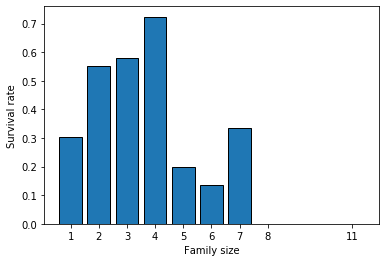

In [35]:
x = family_survived.index
plt.bar(x, family_survived, edgecolor='k', linewidth=1)
plt.xlabel('Family size')
plt.ylabel('Survival rate')
plt.xticks(x)
plt.show()

As expected, there appears to be a peak in survival rates amongst 3 and 4 person families. Meanwhile, larger families had notably lower chances.

## Prepare the data

Time to clean and construct some new features based on the findings above.

In [36]:
all_data.head()

Survived  Pclass                                               Name  \
0       0.0       3                            Braund, Mr. Owen Harris   
1       1.0       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2       1.0       3                             Heikkinen, Miss. Laina   
3       1.0       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4       0.0       3                           Allen, Mr. William Henry   

      Sex   Age  SibSp  Parch     Fare Cabin Embarked Title Deck  Family_size  
0    male  22.0      1      0   7.2500   NaN        S    Mr  NaN            2  
1  female  38.0      1      0  71.2833   C85        C   Mrs    C            2  
2  female  26.0      0      0   7.9250   NaN        S  Miss  NaN            1  
3  female  35.0      1      0  53.1000  C123        S   Mrs    C            2  
4    male  35.0      0      0   8.0500   NaN        S    Mr  NaN            1

 Let's include a 'Reverend' column:

In [37]:
all_data['Reverend'] = (all_data['Title'] == 'Rev').astype(int)

And drop some more no longer important features:

In [38]:
all_data.drop(['Name', 'Cabin', 'Title'], axis=1, inplace=True)

Now we'll one-hot encode the remaining categorical features. We can also drop some of the resulting columns that are mutually exclusive to the others in their group:

In [39]:
all_data = pd.get_dummies(all_data)
print(all_data.columns)

Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Family_size',
       'Reverend', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E',
       'Deck_F', 'Deck_G', 'Deck_T'],
      dtype='object')


In [40]:
all_data.drop(['Family_size', 'Sex_female', 'Embarked_C', 'Embarked_Q'], axis=1, inplace=True)

In [41]:
all_data.head()

Survived  Pclass   Age  SibSp  Parch     Fare  Reverend  Sex_male  \
0       0.0       3  22.0      1      0   7.2500         0         1   
1       1.0       1  38.0      1      0  71.2833         0         0   
2       1.0       3  26.0      0      0   7.9250         0         0   
3       1.0       1  35.0      1      0  53.1000         0         0   
4       0.0       3  35.0      0      0   8.0500         0         1   

   Embarked_S  Deck_A  Deck_B  Deck_C  Deck_D  Deck_E  Deck_F  Deck_G  Deck_T  
0           1       0       0       0       0       0       0       0       0  
1           0       0       0       1       0       0       0       0       0  
2           1       0       0       0       0       0       0       0       0  
3           1       0       0       1       0       0       0       0       0  
4           1       0       0       0       0       0       0       0       0

## Create train and test datasets

Now we need to chop the data up into training and testing sets. First let's pull out the non-submission data, which is needed to train the models and get an idea of model accuracy:

In [42]:
X_data = all_data.drop(labels=['Survived'], axis=1)
X_columns = list(X_data.columns)
X_data = X_data.values
y_data = all_data['Survived'].values
Xtt_data = X_data[:train_size]
ytt_data = y_data[:train_size].astype(int)

Scale this data:

In [43]:
scaler = StandardScaler().fit(Xtt_data)
Xtt_data = scaler.transform(Xtt_data)

Divide it up into training and testing sets:

In [44]:
X_train, X_test, y_train, y_test = train_test_split(Xtt_data, ytt_data, test_size=0.2)

## Train and test some models...

Let's try a variety of different models, and see how the accuracy compares between them.

### Logistic Regression

In [45]:
lr = LogisticRegression(solver='lbfgs').fit(X_train, y_train)
score = lr.score(X_test, y_test)
print(f'Accuracy: {100 * np.round(score, 2)}%')

Accuracy: 82.0%


### Support Vector Classifier

In [46]:
svc = SVC(C=1., gamma='scale', probability=True).fit(X_train, y_train)
score = svc.score(X_test, y_test)
print(f'Accuracy: {100 * np.round(score, 2)}%')

Accuracy: 80.0%


### Random Forest

In [47]:
rf = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)
score = rf.score(X_test, y_test)
print(f'Accuracy: {np.round(100 * score, 2)}%')

Accuracy: 82.68%


### Gradient Boosting Classifier

In [48]:
gb = GradientBoostingClassifier(n_estimators=100).fit(X_train, y_train)
score = gb.score(X_test, y_test)
print(f'Accuracy: {np.round(100 * score, 2)}%')

Accuracy: 81.01%


### Composite model

Finally, let's leverage this model variety by combining their individual probabilistic predictions to produce a final weighted prediction:

In [49]:
def composite_model(X_test, *models):
    preds = []
    for model in models:
        proba = model.predict_proba(X_test)
        preds.append(proba[:,1])
    preds = np.mean(np.array(preds), axis=0)
    preds = np.round(preds, 0).astype(int)
    return preds         

In [50]:
predictions = composite_model(X_test, lr, svc, rf, gb)

In [51]:
size = len(predictions)
accuracy = 100 * (size - np.sum(np.abs(predictions - y_test))) / size
print(f'Accuracy: {np.round(accuracy, 2)}%')

Accuracy: 82.68%


This final model returns an accuracy of roughly just over 80%, which is fairly decent compared to the Kaggle scoreboard.

## Make predictions for submission

This final section generates predictions based on the original test (submission) dataset, and writes it to csv in the submission format accepted by Kaggle.

In [52]:
Xs_data = X_data[train_size:]
Xs_data = scaler.transform(Xs_data)

In [53]:
predictions = composite_model(Xs_data, lr, svc, rf, gb)

In [57]:
# check the output...
predictions[:10]

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0])

In [58]:
result = pd.DataFrame(
    np.array([ids[train_size:].values, predictions]).T,
    columns=['PassengerId', 'Survived']
)
result.head()

PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1

In [59]:
result.to_csv('./data/submission.csv', index=False)